Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\shrey\anaconda3\New folder\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:15:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Model saved as 'heart_disease_rf_model.pkl'
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Accuracy: 0.8833333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90        35
           1       0.88      0.84      0.86        25

    accuracy                           0.88        60
   macro avg       0.88      0.88      0.88        60
weighted avg       0.88      0.88      0.88        60

Confusion Matrix:
 [[32  3]
 [ 4 21]]


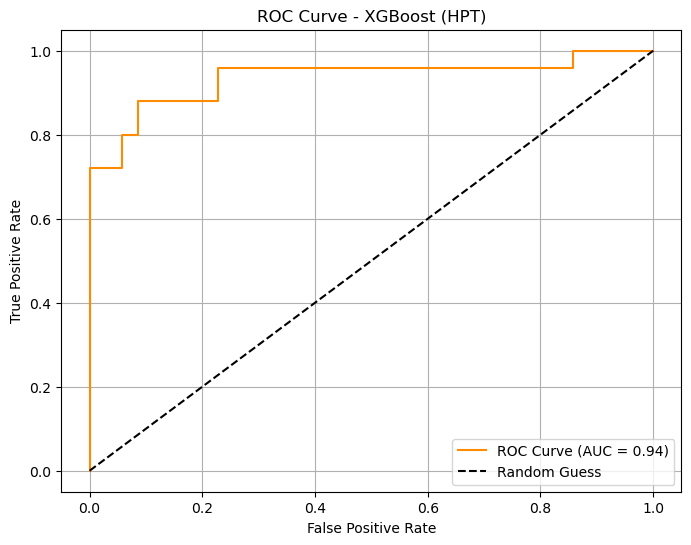

Index Prob       Pred   Risk Level
0     0.974      1      High Risk
1     0.013      0      Low Risk
2     0.420      0      Moderate Risk
3     0.921      1      High Risk
4     0.075      0      Low Risk
5     0.988      1      High Risk
6     0.014      0      Low Risk
7     0.964      1      High Risk
8     0.028      0      Low Risk
9     0.996      1      High Risk


In [1]:
#xgb with hpt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv('heart_disease_uci.csv')

# Drop unnecessary columns
df = df.drop(['id', 'dataset'], axis=1)
df = df.dropna()

# Encode categorical features
label_encoders = {}
for col in df.columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Binarize target column
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

# Split features and target
X = df.drop('num', axis=1)
y = df['num']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost and parameter grid
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
}

# Grid search
grid = GridSearchCV(xgb, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# Best model
best_model = grid.best_estimator_
best_params = grid.best_params_

import joblib

# Save the best model to a .pkl file
joblib.dump(best_model, 'heart_disease_rf_model.pkl')
print("✅ Model saved as 'heart_disease_rf_model.pkl'")

# Predictions
y_pred_xgb = best_model.predict(X_test)

# Evaluation
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_prob_xgb = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_xgb)
auc_score = roc_auc_score(y_test, y_prob_xgb)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (HPT)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

confidence = best_model.predict_proba(X_test)[:, 1]
preds = [1 if prob > 0.7 else 0 for prob in confidence]

def risk_score(prob):
    if prob < 0.3:
        return "Low Risk"
    elif prob < 0.6:
        return "Moderate Risk"
    else:
        return "High Risk"

# Print for a few test cases
print(f"{'Index':<5} {'Prob':<10} {'Pred':<6} {'Risk Level'}")
print("=" * 35)
for i, prob in enumerate(confidence[:10]):  # Show only first 10 samples
    print(f"{i:<5} {prob:<10.3f} {preds[i]:<6} {risk_score(prob)}")


Best k: 19
Accuracy: 0.85

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.88        35
           1       0.86      0.76      0.81        25

    accuracy                           0.85        60
   macro avg       0.85      0.84      0.84        60
weighted avg       0.85      0.85      0.85        60

Confusion Matrix:
 [[32  3]
 [ 6 19]]


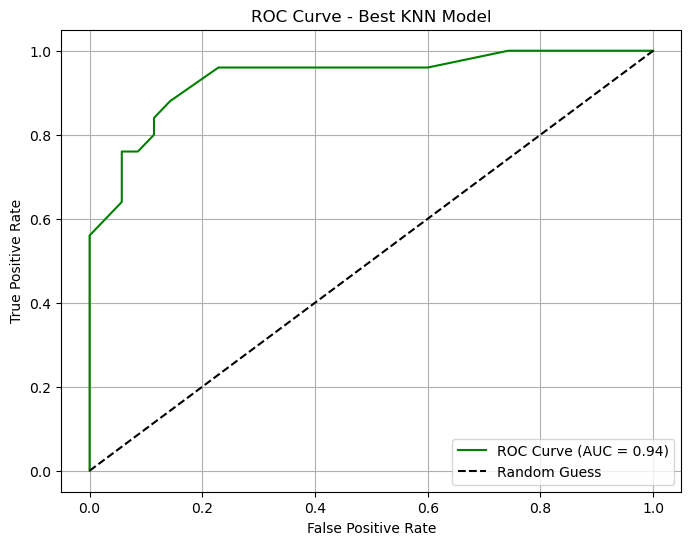

In [2]:
#knn with hpt
from sklearn.neighbors import KNeighborsClassifier

# Load dataset
df = pd.read_csv('heart_disease_uci.csv')

# Drop unnecessary columns
df = df.drop(['id', 'dataset'], axis=1)
df = df.dropna()

# Encode categorical variables
label_encoders = {}
for col in df.columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Binarize target
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

# Split features and target
X = df.drop('num', axis=1)
y = df['num']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Grid search for best k
param_grid = {'n_neighbors': list(range(1, 21))}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

# Best model
best_k = grid.best_params_['n_neighbors']
best_model = grid.best_estimator_

# Predictions
y_pred_knn = best_model.predict(X_test)

# Evaluation
print(f"Best k: {best_k}")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Probabilities for the positive class
y_prob_knn = best_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_knn)
auc_score = roc_auc_score(y_test, y_prob_knn)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best KNN Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



Decision Tree Best Params: {'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 5}
Accuracy: 0.7666666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80        35
           1       0.72      0.72      0.72        25

    accuracy                           0.77        60
   macro avg       0.76      0.76      0.76        60
weighted avg       0.77      0.77      0.77        60

Confusion Matrix:
 [[28  7]
 [ 7 18]]


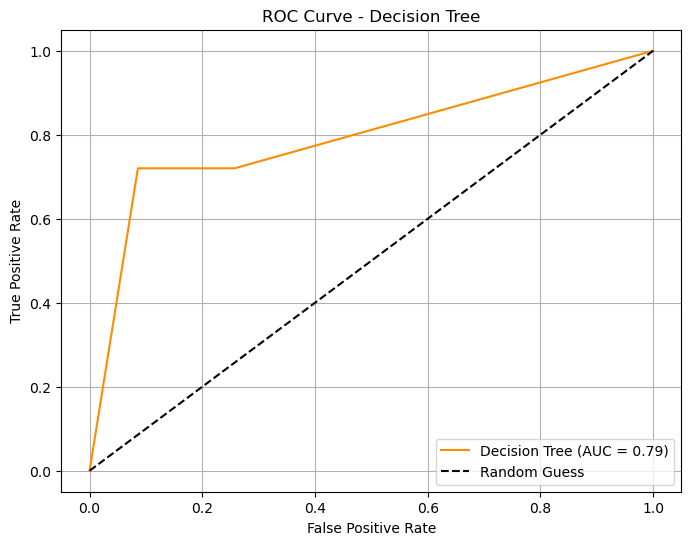

In [3]:
#dt with hpt

from sklearn.tree import DecisionTreeClassifier

# Load dataset
df = pd.read_csv('heart_disease_uci.csv')
df = df.drop(['id', 'dataset'], axis=1).dropna()

# Encode categorical variables
label_encoders = {}
for col in df.columns:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Binarize target
df['num'] = df['num'].apply(lambda x: 1 if x > 0 else 0)

# Features and target
X = df.drop('num', axis=1)
y = df['num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter grid for Decision Tree
param_grid_dt = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)
grid_dt = GridSearchCV(dt, param_grid_dt, cv=5)
grid_dt.fit(X_train, y_train)

best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)

# Evaluation
print("Decision Tree Best Params:", grid_dt.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the positive class
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='darkorange', label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guess')

plt.title('ROC Curve - Decision Tree')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()



Fitting 5 folds for each of 36 candidates, totalling 180 fits
Random Forest Best Params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 150}
Accuracy: 0.8666666666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89        35
           1       0.84      0.84      0.84        25

    accuracy                           0.87        60
   macro avg       0.86      0.86      0.86        60
weighted avg       0.87      0.87      0.87        60

Confusion Matrix:
 [[31  4]
 [ 4 21]]


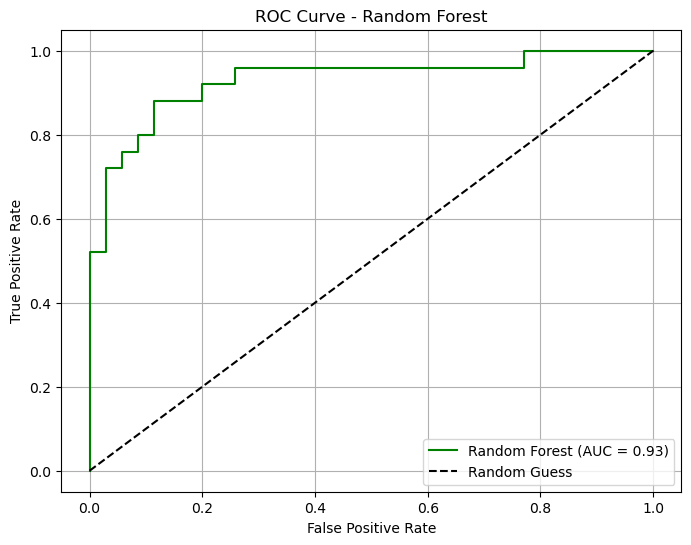

In [4]:
#rf with hpt
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Evaluation
print("Random Forest Best Params:", grid_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probability estimates for the positive class
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='green', label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guess')

plt.title('ROC Curve - Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()


C:\Users\shrey\AppData\Local\Temp\ipykernel_25548\1496827314.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=[results[model][metric] for model in results], palette='viridis')


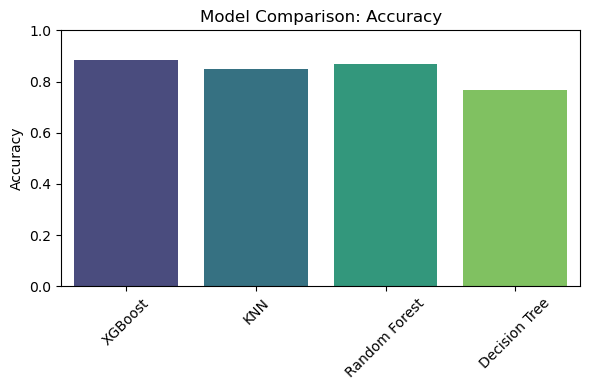

C:\Users\shrey\AppData\Local\Temp\ipykernel_25548\1496827314.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=[results[model][metric] for model in results], palette='viridis')


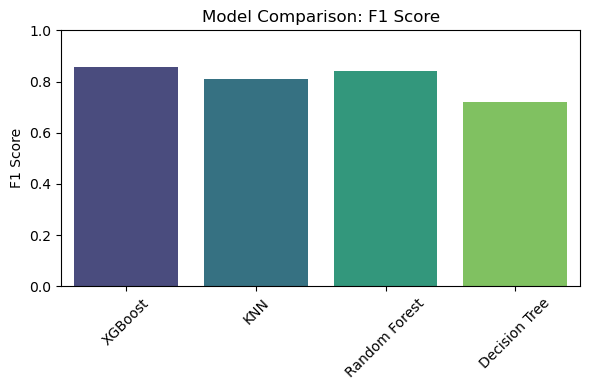

C:\Users\shrey\AppData\Local\Temp\ipykernel_25548\1496827314.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=[results[model][metric] for model in results], palette='viridis')


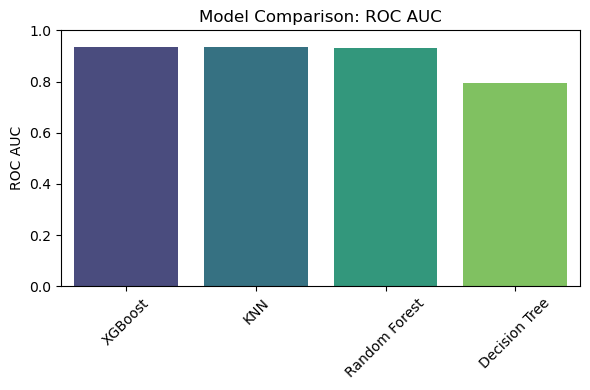

Best Accuracy: 0.8833 (XGBoost)
Best F1 Score: 0.8571 (XGBoost)
Best ROC AUC: 0.9360 (XGBoost)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

# Define models and their predictions
models = {
    "XGBoost": {"y_pred": y_pred_xgb, "y_prob": y_prob_xgb},
    "KNN": {"y_pred": y_pred_knn, "y_prob": y_prob_knn},
    "Random Forest": {"y_pred": y_pred_rf, "y_prob": y_proba_rf},
    "Decision Tree": {"y_pred": y_pred_dt, "y_prob": y_proba_dt}
}

results = {}

# Compute metrics
for model_name, preds in models.items():
    y_pred = preds["y_pred"]
    y_prob = preds["y_prob"]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)

    results[model_name] = {"Accuracy": acc, "F1 Score": f1, "ROC AUC": roc}

# Plot comparison graphs
metrics = ["Accuracy", "F1 Score", "ROC AUC"]
for metric in metrics:
    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(results.keys()), y=[results[model][metric] for model in results], palette='viridis')
    plt.title(f'Model Comparison: {metric}')
    plt.ylabel(metric)
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Print the best scores
for metric in metrics:
    best_model = max(results, key=lambda x: results[x][metric])
    print(f"Best {metric}: {results[best_model][metric]:.4f} ({best_model})")
